In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)


In [3]:
# sector-> Food & Drug store(2017/01/01~2020/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


# Make models

In [9]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("Volume含む")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("Volume含まない")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    if V:
      print("Here check")
      print(f"output=1, inputs={v}, outputs={output_c}")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("volule以外かつinputとoutputは1つ")
      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()
      ss_others=ss2.fit_transform(training_set_all)
      concat=ss_others

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  print("Check")
  model_lists = []
  for l in range(len(y_trains2)):
    print(f"{l+1}/{len(y_trains2)}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  print("finish making models")
  return model_lists, y_trains2

# Make preds

In [5]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  print(f"inputs = {np.array(inputs).shape}")

  #train_data=(11, 754, 2), test_data=(11, 252, 2)
  # inputs = (11, 282, 2)
  # Volumeを含むケース
  # inputs = (11, 282, 2)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  print(f"inputs2={inputs2.shape}")
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")
  #X_test=(252, 30, 22)

  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]
    print(ind)

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual lists={np.array(actual_lists).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(r)
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    # plt.title(f"{}")
    plt.xlabel('Time series')
    plt.ylabel('Stock Price (or Volume)')
    
    # use correlation
    print(f"R2{R2[p]}={r2_score(actual_lists[p], preds[p].flatten())}")
 
    R +=r2_score(actual_lists[p], preds[p].flatten())
    plt.legend()
    plt.show()

    if p in r:
      print(f"R2-{len(c)}companies_average={R/len(c)}")
      R=0
      print("")

  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  for p in range(len(output_i)):
    print(f"Preds_Heatmap={output_c[p]} correlation")
    prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
    # print(len(prd))
    Preds= pd.DataFrame(np.concatenate(prd, axis=1))
    Preds.columns = columns
    # print(Preds.columns)
    plt.figure(figsize=(8, 6))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# "Experiments"
###Sector: Food & Drug
### Criteria: Profits/Employees 

# [What I got from various experiments]
### It can be difficult to decrease Loss function in the case of 'Only Volume'
### As time_step increases, R2 decreases.
### As number of epoch increases, R2 generally increases (Except for 'Volume')
### Even if number of neurons increase, not necesssarily increase R2 (too much may contribute to overfit)


# 6月9日以降　
####(1) まずはランダム２社選択して、HighとValueそれぞれのR2を算出していく
####(2) R2>=0.9(最悪R2>=0.8)ならばOKで３社,４社・・・・と増やしていく
####(3) 何社目に増やしたところでスコアが急激に落ちるかデータを取る

In [ ]:
# 集計データ {time_step=60days, number_of_epoch=20time, number_of_neuron=50}
R2_Score_HighPrice = {"2":　0.70, "3": 0.50}
R2_Score_Volume = {}

In [8]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=50 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [10]:
# default: make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60, epochs=30, units=50)
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(2, 754, 1), test_data=(2, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=2, ind=[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
Check
1/2
Epoch 1/20
22/22 [==============================] - 8s 105ms/step - loss: 0.6664
Epoch 2/20
22/22 [==============================] - 2s 108ms/step - loss: 0.2387
Epoch 3/20
22/22 [==============================] - 2s 106ms/step - loss: 0.1382
Epoch 4/20
22/22 [==============================] - 2s 107ms/step - loss: 0.1417
Epoch 5/20
22/22 [==============================] - 3s 118ms/step - loss: 0.1287
Epoch 6/20
22/22 [==============================] - 2s 106ms/step - loss: 0.1043
Epoch 7/20
22/22 [==============================] - 2s 110ms/step - loss: 0.1131
Epoch 8/20
22/22 [==============================] - 2s 107ms/step - loss: 0.1102
Epoch 9/20
22/22 [==============================] - 2s 107ms/step - loss: 0.0985
Epoch 10/20
22/22 [==============================] - 2s 104ms/step - loss: 0.0932
Epoch 11/20
22/22 

train_data=(2, 754, 1), test_data=(2, 252, 1)
inputs = (2, 312, 1)
inputs2=(312, 2)
X_test=(252, 60, 2)
finish making predictions
actual lists=(2, 252), preds_list=(2, 252, 1)
[1]
R2Seven & I Holdings (Japan)=0.5673760346707963


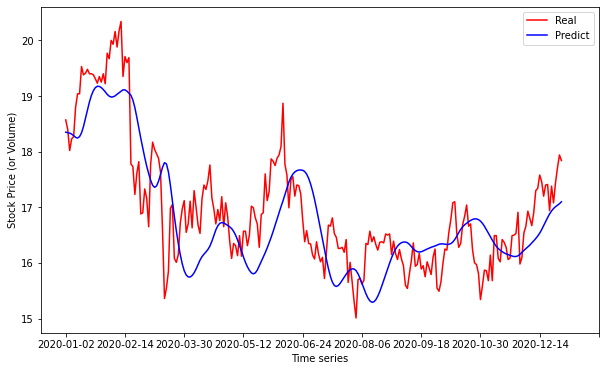

R2Walgreens Boots Alliance (USA)=0.8376277788350628


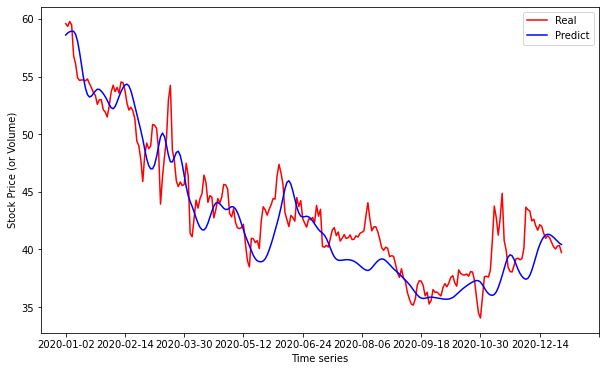

R2-2companies_average=0.7025019067529296

Preds_Heatmap=High correlation


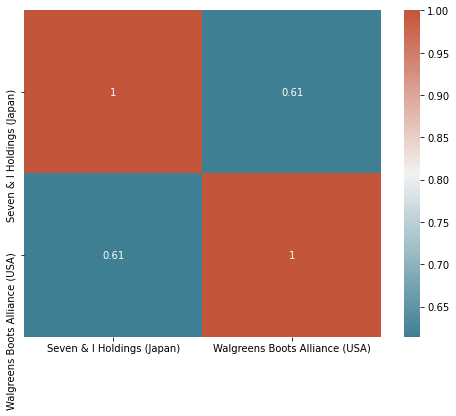

In [11]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [12]:
data=[df1, df2, df3] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=50 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [13]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(3, 754, 1), test_data=(3, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=3, ind=[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
Check
1/3
Epoch 1/20
22/22 [==============================] - 8s 114ms/step - loss: 0.5810
Epoch 2/20
22/22 [==============================] - 2s 109ms/step - loss: 0.1811
Epoch 3/20
22/22 [==============================] - 2s 105ms/step - loss: 0.1245
Epoch 4/20
22/22 [==============================] - 2s 106ms/step - loss: 0.1211
Epoch 5/20
22/22 [==============================] - 2s 105ms/step - loss: 0.0965
Epoch 6/20
22/22 [==============================] - 2s 108ms/step - loss: 0.1121
Epoch 7/20
22/22 [==============================] - 2s 112ms/step - loss: 0.1039
Epoch 8/20
22/22 [==============================] - 2s 103ms/step - loss: 0.0900
Epoch 9/20
22/22 [==============================] - 2s 111ms/step - loss: 0.0790
Epoch 10/20
22/22 [==============================] - 2s 106ms/step - loss: 0.0908
Epoch 11/20
22/

train_data=(3, 754, 1), test_data=(3, 252, 1)
inputs = (3, 312, 1)
inputs2=(312, 3)
X_test=(252, 60, 3)
finish making predictions
actual lists=(3, 252), preds_list=(3, 252, 1)
[2]
R2Seven & I Holdings (Japan)=0.15465857038819275


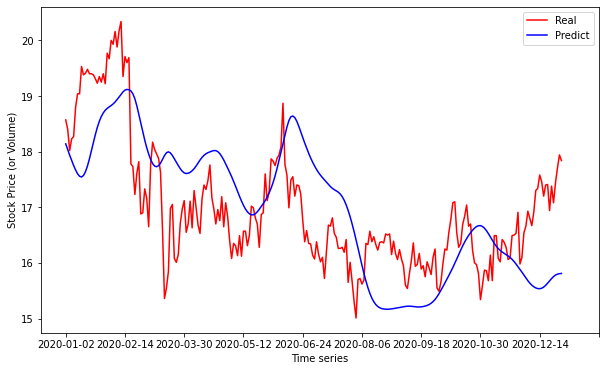

R2Walgreens Boots Alliance (USA)=0.6652851614055248


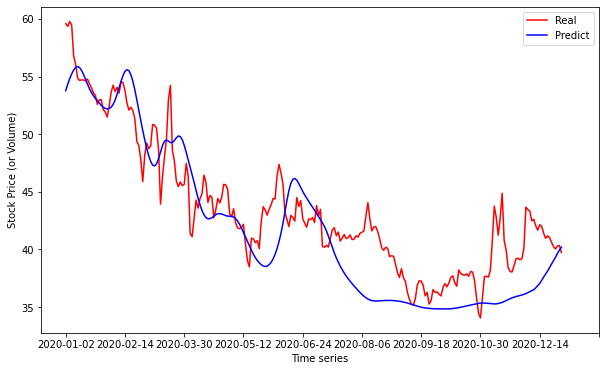

R2Metro (Canada)=0.6809123815525806


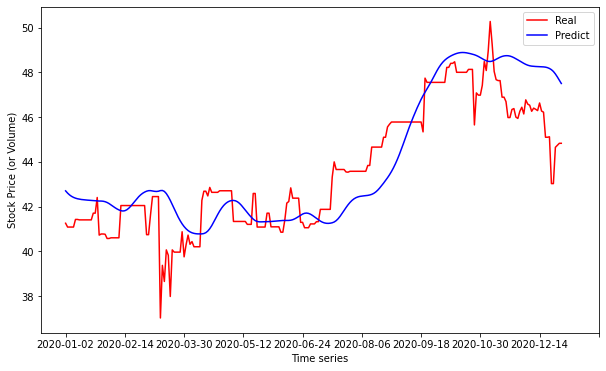

R2-3companies_average=0.5002853711154328

Preds_Heatmap=High correlation


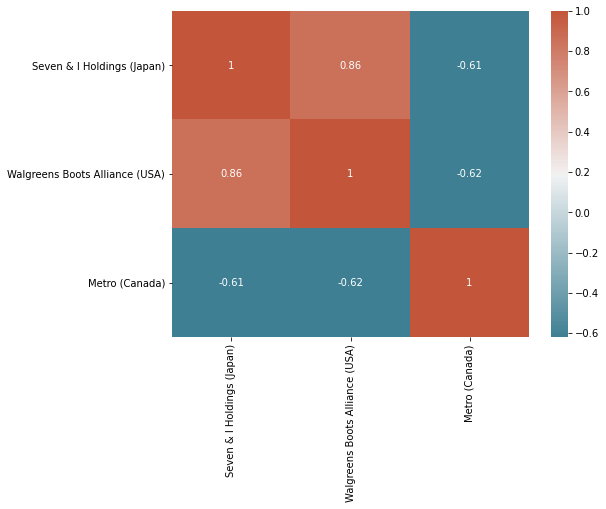

In [14]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)